In [1]:
from transformers import pipeline

In [14]:
import torch
torch.__version__

'2.1.1+cu121'

In [2]:
device= 0
classifier = pipeline("text-classification", "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", device=device)
summerizer = pipeline("summarization", "facebook/bart-large-cnn")

In [3]:
import requests
import json
import datetime


with open("credential", "r") as f:
    jsonStr = f.read()
    creds = json.loads(jsonStr)


def fetchNews(start:datetime.datetime, end:datetime.datetime, symbols:str, limit:int=20, include_content:bool=True, exclude_contentless:bool=True):
    newsList = []
    startStr = start.strftime("%Y-%m-%dT%H:%M:%SZ")
    endStr = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}"
    headers = {"accept": "application/json", "APCA-API-KEY-ID": creds["alpacaPaper"][0], "APCA-API-SECRET-KEY": creds["alpacaPaper"][1]}

    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
    data = resp.json()
    news = data.get("news", [])
    newsList.extend(news)
    next_page_token = data.get("next_page_token", None)
    while next_page_token:
        url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}&page_token={next_page_token}"
        resp = requests.get(url, headers=headers)
        if resp.status_code != 200:
            raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
        data = resp.json()
        news = data.get("news", [])
        newsList.extend(news)
        next_page_token = data.get("next_page_token", None)
    return newsList


news = fetchNews(datetime.datetime.now()-datetime.timedelta(days=14), datetime.datetime.now(), "NVDA", 50, True, True)  
len(news)

154

In [4]:
news[0]

{'author': 'Benzinga Neuro',
 'content': '<p><strong>Tastytrade</strong> founder <strong>Tom Sosnoff</strong> spotlighted the remarkable trading activity of <strong>Nvidia Corporation</strong> (NASDAQ:<a class="ticker" href="https://www.benzinga.com/stock/NVDA#NASDAQ">NVDA</a>). </p>\n\n\n\n<p><strong>What Happened</strong>: Talking to CNBC&#8217;s &#8220;Last Call,&#8221; Sosnoff described that Nvidia&#8217;s current market position has very little to do with its fundamental story.</p>\n\n\n\n<p>&#8220;You&#8217;re talking about a stock at this point, it&#8217;s a $900 stock that&#8217;s trading with penny-wide markets. The depth of liquidity today in Nvidia was off the charts. I mean it was the number one stock traded on our platform today. It just crushed everything else,&#8221; he said.</p>\n\n\n\n<p>Sosnoff also added that Nvidia will continue picking up steam with many retail customers getting attracted to the prospects. &#8220;It&#8217;s A Beast,&#8221; he said.</p>\n\n\n\n<p>&#

In [5]:
import regex as re

htmlElement = re.compile(r"<.*?>")
def preprocessTexts(text):
    # remove html elements
    processed = re.sub(htmlElement, "", text)
    # remove spaces
    processed = re.sub(r"\s+", " ", processed)
    # replace special characters
    processed = re.sub(r"&#[0-9]+;", " ", processed)
    return processed


simpleNews = [{
    "id": n["id"],
    "title": n["headline"],
    "content": preprocessTexts(n["content"]),
    "summary":n["summary"],
    "time": n["created_at"],
    "source": n["source"],
    "symbols": n["symbols"],
} for n in news]

In [8]:
classifier(simpleNews[0]["summary"], return_all_scores=True)

c:\Users\zizh3\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'negative', 'score': 0.00022091210121288896},
  {'label': 'neutral', 'score': 0.00011859311780426651},
  {'label': 'positive', 'score': 0.9996604919433594}]]

In [9]:
summerizer(simpleNews[0]["content"])

[{'summary_text': 'Tastytrade founder Tom Sosnoff spotlighted the remarkable trading activity of Nvidia Corporation (NASDAQ:NVDA) He described that Nvidia s current market position has very little to do with its fundamental story. He added that Nvidia will continue picking up steam with many retail customers getting attracted to the prospects.'}]

In [6]:
noSummaryNews = [n for n in simpleNews if n.get("summary", None) is None or len(n["summary"].strip()) == 0]

<Axes: >

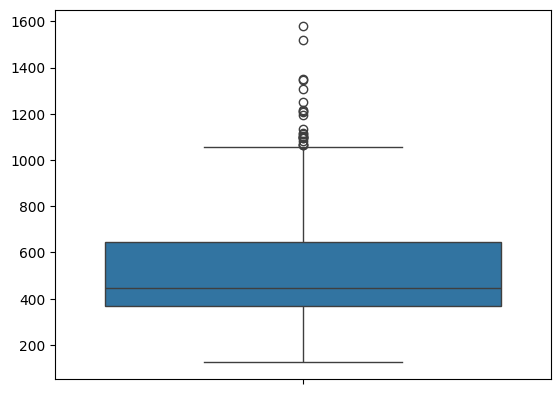

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


tokenLength = [len(n["content"].split()) for n in simpleNews]
sns.boxplot(tokenLength)

In [10]:
scores = classifier([
    n["summary"] for n in simpleNews
], return_all_scores=True)

c:\Users\zizh3\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
processedScores = [
    {
        "negative": s[0]["score"],
        "neutral": s[1]["score"],
        "positive": s[2]["score"],
        "label": "positive" if s[2]["score"] > s[0]["score"] else "negative" if s[0]["score"] > s[2]["score"] else "neutral",
    } for s in scores
]

df = pd.DataFrame(processedScores)
df["time"] = [n["time"] for n in simpleNews]
df["summary"] = [n["summary"] for n in simpleNews]
df["content"] = [n["content"] for n in simpleNews]
df["symbols"] = [n["symbols"] for n in simpleNews]
df["relative_weight"] = [1/len(n["symbols"]) for n in simpleNews]
df["source"] = [n["source"] for n in simpleNews]
df.head()

,negative,neutral,positive,label,time,summary,content,symbols,relative_weight,source
0,0.000208,0.000127,0.999665,positive,2024-03-07T21:30:30Z,Gold miners outperform semiconductor industry ...,If someone were to tell you that NVIDIA Corp. ...,"[AU, CDE, DRD, GDX, GSISF, NVDA, OCANF, PMNXF,...",0.100000,benzinga
1,0.000190,0.000107,0.999703,positive,2024-03-07T20:20:02Z,Nvidia has gained more than $1 trillion in mar...,We ve written a lot over the past months — as ...,"[AAPL, NVDA, TSLA]",0.333333,benzinga
2,0.001164,0.078514,0.920322,positive,2024-03-07T19:44:44Z,"To gain an edge, this is what you need to know...","To gain an edge, this is what you need to know...","[AAPL, AMZN, BTCUSD, GLD, GOOG, META, MSFT, NV...",0.076923,benzinga
3,0.000203,0.000251,0.999546,positive,2024-03-07T18:32:36Z,"The S&amp;P 500 soared past the 5,150-point ma...","The S&amp;P 500 soared past the 5,150-point ma...","[ABM, AEO, AGR, AVGO, BBAI, BILI, BJ, BTCUSD, ...",0.030303,benzinga
4,0.000218,0.000089,0.999693,positive,2024-03-07T18:22:18Z,Analyst Vijay Rakesh reiterated Buy ratings on...,Mizuho&nbsp;analyst Vijay Rakesh reiterated a ...,"[AMD, ARM, AVGO, BOTZ, INTC, NVDA, SMH]",0.142857,benzinga


<Axes: >

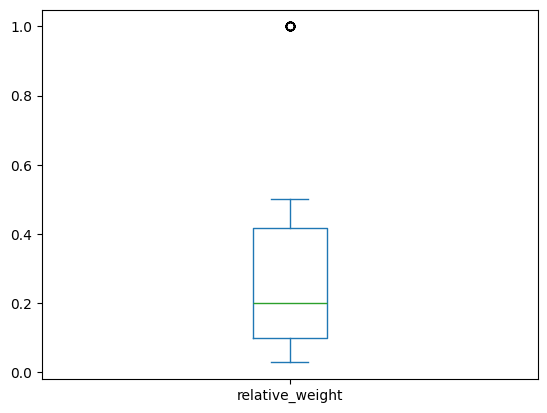

In [12]:
df.relative_weight.plot.box()

In [13]:
df.to_csv("news.csv", index=False)